<a href="https://colab.research.google.com/github/w2j1y12/pdm17/blob/main/py-tensorflow/DL2-CNN/dl2_02_mnist_CNN_best.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CNN model of mnist dataset**
- Conv2D + FCN
    * Conv2D : 2차원 합성곱 필터링 + 풀링(Pooling)
    - > 2차원 필터로 영상을 대표하는 특징을 추출
    * FCN : 1차원 완전연결신경망
    - > Conv2D에서 추출된 대표 특징들을 이용하여 FCN으로 최종 학습 완료

***
- ## Traget: **Find the best model**
***

![mnist_NN_2_layers](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FdJp5Z6%2FbtqAPebnF3x%2FQCe5vVcskhmxe964bGz4iK%2Fimg.png)

(source: https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FdJp5Z6%2FbtqAPebnF3x%2FQCe5vVcskhmxe964bGz4iK%2Fimg.png)

## Search the best model of C2F2
- callback
    - Early stopping
    - model checkpoint

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline

print(tf.__version__)
tf.random.set_seed(0)

2.7.0


In [2]:
# import TF2 submodules
from tensorflow.keras import layers, models, callbacks

## **데이터 로딩, 정규화**

In [3]:
from keras.datasets import mnist

(X_train0, y_train0), (X_test0, y_test0) = mnist.load_data()

# Reshape
X_train = X_train0.reshape(60000,28,28,1)
X_test = X_test0.reshape(10000,28,28,1)

# Normalization
X_train, X_test = X_train/255.0, X_test/255.0 # 정규화

print("X_train={0}".format(X_train.shape))
print("y_train={0}".format(y_train0.shape)) 
print("X_test={0}".format(X_test.shape))
print("y_test={0}".format(y_test0.shape))

11501568/11490434 [==============================] - 0s 0us/step
X_train=(60000, 28, 28, 1)
y_train=(60000,)
X_test=(10000, 28, 28, 1)
y_test=(10000,)


In [4]:
# One-Hot-Encoding
# Use function to_categorical() to do One-Hot-Encoding
# tf.keras.utils.to_categorical
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)
y_train.shape,y_test.shape

((60000, 10), (10000, 10))

In [5]:
# y_train0.shape vs. y_train.shape
y_train0.shape, y_train.shape

((60000,), (60000, 10))

### Display numbers
- one random number
- 10 representative numbers

27028


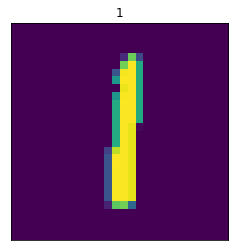

In [6]:
# Code here!
# display one random image from the training set:
class_names = ["0","1","2","3","4","5","6","7","8","9"]

idx = np.random.randint(0, X_train0.shape[0])
print(idx)
image = X_train0[idx]
plt.imshow(image) #, cmap=plt.get_cmap('gray'))
plt.title(class_names[y_train0[idx]])
plt.xticks([])
plt.yticks([])
plt.show()

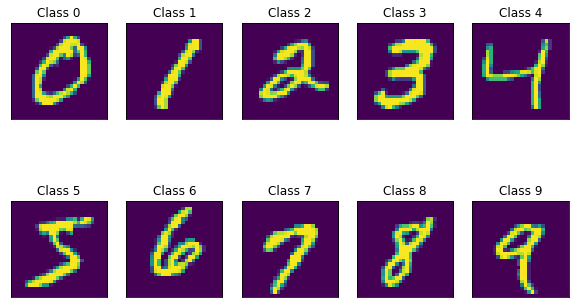

In [7]:
fig = plt.figure(figsize=(10,6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    num0_9 = X_train0[y_train0 == i]
    # print(num0_9.shape)
    plt.imshow(num0_9[0]) #, cmap='gray') #, interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])

# Design CNN

### import models, layers, callbacks
- models: Sequential
- layers: Conv2D, MaxPool2D, Flatten
- callbacks: ModelCheckpoint, EarlyStopping

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping

## **CNN2 + FCN2**

In [9]:
# Random number seed
np.random.seed(1234)
tf.random.set_seed(1234)

In [10]:
c2f2 = keras.models.Sequential([ 
    Conv2D(input_shape=(28,28,1),kernel_size=(3,3),strides=(1,1),filters= 64,padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)), 
    Conv2D(kernel_size=(3,3),strides=(1,1),filters= 32,padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),
    Flatten(), 
    keras.layers.Dense(128, activation='relu'),  
    keras.layers.Dropout(0.25), 
    keras.layers.Dense(10, activation='softmax')
])

c2f2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']) 

In [11]:
c2f2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 dense (Dense)               (None, 128)               2

In [12]:
mc_callback = callbacks.ModelCheckpoint(filepath="./mnist_c2f2_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=10)    # patience=10, 20, 50

In [13]:
# Train CNN model
# Find and save the best model.
hist = c2f2.fit(X_train, y_train, epochs = 500 , batch_size =100, 
         callbacks=[mc_callback, es_callback], 
         validation_data=(X_test,y_test))

Epoch 1/500
600/600 [==============================] - 19s 11ms/step - loss: 0.2204 - accuracy: 0.9328 - val_loss: 0.0511 - val_accuracy: 0.9845
Epoch 2/500
600/600 [==============================] - 6s 10ms/step - loss: 0.0666 - accuracy: 0.9799 - val_loss: 0.0344 - val_accuracy: 0.9889
Epoch 3/500
600/600 [==============================] - 6s 10ms/step - loss: 0.0466 - accuracy: 0.9854 - val_loss: 0.0315 - val_accuracy: 0.9903
Epoch 4/500
600/600 [==============================] - 6s 9ms/step - loss: 0.0365 - accuracy: 0.9888 - val_loss: 0.0282 - val_accuracy: 0.9899
Epoch 5/500
600/600 [==============================] - 6s 10ms/step - loss: 0.0295 - accuracy: 0.9902 - val_loss: 0.0244 - val_accuracy: 0.9921
Epoch 6/500
600/600 [==============================] - 6s 9ms/step - loss: 0.0260 - accuracy: 0.9918 - val_loss: 0.0260 - val_accuracy: 0.9910
Epoch 7/500
600/600 [==============================] - 6s 9ms/step - loss: 0.0220 - accuracy: 0.9929 - val_loss: 0.0231 - val_accuracy: 0

In [14]:
c2f2.evaluate(X_test, y_test, batch_size =100)

100/100 [==============================] - 0s 5ms/step - loss: 0.0350 - accuracy: 0.9927


[0.034971050918102264, 0.9926999807357788]

## Graph of loss and accuracy
- model: C2F2

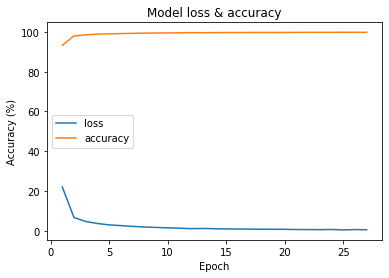

In [15]:
# Plot loass and accuracy
# Plot training & validation accuracy values
loss_list = [100 * i for i in hist.history['loss']]
acc_list = [100 * i for i in hist.history['accuracy']]

epochs = range(1, len(loss_list) + 1)

plt.plot(epochs,loss_list) 
plt.plot(epochs,acc_list) 
plt.title('Model loss & accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['loss', 'accuracy'], loc='center left')

In [16]:
vloss_list = [100 * i for i in hist.history['val_loss']]
vacc_list = [100 * i for i in hist.history['val_accuracy']]

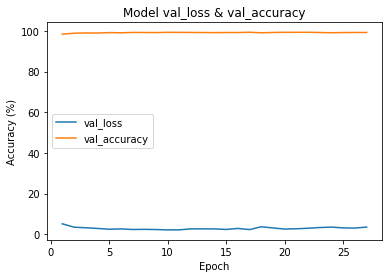

In [17]:
plt.plot(epochs,vloss_list)  
plt.plot(epochs,vacc_list)  
plt.title('Model val_loss & val_accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['val_loss', 'val_accuracy'], loc='center left')

In [18]:
# np.argmax(np.array(vacc_list))

In [19]:
# vacc_list[np.argmax(np.array(vacc_list))]

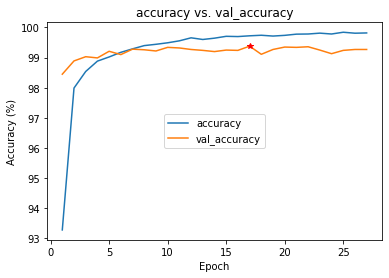

In [20]:
plt.plot(epochs,acc_list)  
plt.plot(epochs,vacc_list)  
plt.title('accuracy vs. val_accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['accuracy','val_accuracy'], loc='center')
plt.plot(np.argmax(np.array(vacc_list))+1,vacc_list[np.argmax(np.array(vacc_list))], 'r*') 

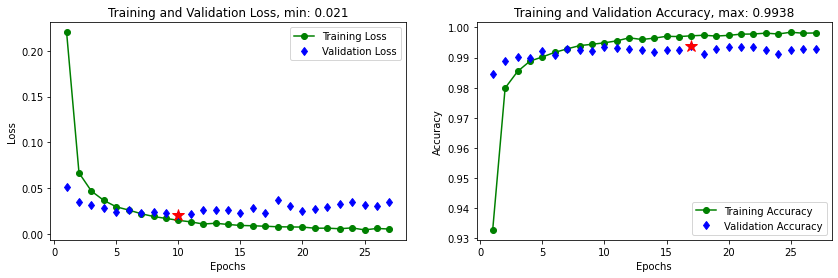

In [21]:
# More graphs of loss and accuracy
history_dict = hist.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'go-', label='Training Loss')
plt.plot(epochs, val_loss, 'bd', label='Validation Loss')
plt.plot(np.argmin(np.array(val_loss))+1,val_loss[np.argmin(np.array(val_loss))], 'r*', ms=12)
plt.title('Training and Validation Loss, min: ' + str(np.round(val_loss[np.argmin(np.array(val_loss))],4)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'go-', label='Training Accuracy') #, c='blue')
plt.plot(epochs, val_acc, 'bd', label='Validation Accuracy') #, c='red')
plt.plot(np.argmax(np.array(val_acc))+1,val_acc[np.argmax(np.array(val_acc))], 'r*', ms=12)
plt.title('Training and Validation Accuracy, max: ' + str(np.round(val_acc[np.argmax(np.array(val_acc))],4)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 훈련 뭐시기 그래프 기본 코드래

## 최적화된 모형 불러와서 이용

- callbacks.ModelCheckpoint를 이용해서 트레이닝 중 val_accuacy가 가장 높은 모형을 가중치와 함께 hdf5 형식으로 저장
- load 명령으로 불러 사용

### Best model
- mnist_c2f2_best_weights.006-0.9921.hdf5

In [23]:
from keras.models import load_model

model = load_model('mnist_c2f2_best_weights.017-0.9938.hdf5')
model.evaluate(X_test, y_test, batch_size=100)

100/100 [==============================] - 1s 6ms/step - loss: 0.0226 - accuracy: 0.9938


[0.022611519321799278, 0.9937999844551086]

## [DIY] C2F3의 best model을 구하시오.

## **CNN2 + FCN3**

과제

In [24]:
# Random number seed
np.random.seed(1234)
tf.random.set_seed(1234)

In [25]:
c2f3 = keras.models.Sequential([ 
    Conv2D(input_shape=(28,28,1),filters= 32, 
                kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)), 
    Conv2D(filters= 64, 
                kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),
    Flatten(), 
    keras.layers.Dense(128, activation='relu'),  
    keras.layers.Dropout(0.25), 
    keras.layers.Dense(64, activation='relu'),  
    keras.layers.Dropout(0.25), 
    keras.layers.Dense(10, activation='softmax')
])

c2f3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']) 

In [26]:
c2f3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [27]:
mc_callback = callbacks.ModelCheckpoint(filepath="./mnist_c2f3_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=10) 

In [28]:
# Train CNN model
# Find and save the best model.
hist = c2f3.fit(X_train, y_train, epochs = 500 , batch_size =100, 
         callbacks=[mc_callback, es_callback], 
         validation_data=(X_test,y_test))

Epoch 1/500
600/600 [==============================] - 8s 11ms/step - loss: 0.2842 - accuracy: 0.9112 - val_loss: 0.0569 - val_accuracy: 0.9813
Epoch 2/500
600/600 [==============================] - 6s 10ms/step - loss: 0.0830 - accuracy: 0.9763 - val_loss: 0.0361 - val_accuracy: 0.9892
Epoch 3/500
600/600 [==============================] - 6s 11ms/step - loss: 0.0562 - accuracy: 0.9834 - val_loss: 0.0368 - val_accuracy: 0.9884
Epoch 4/500
600/600 [==============================] - 6s 10ms/step - loss: 0.0475 - accuracy: 0.9864 - val_loss: 0.0304 - val_accuracy: 0.9903
Epoch 5/500
600/600 [==============================] - 6s 10ms/step - loss: 0.0381 - accuracy: 0.9890 - val_loss: 0.0305 - val_accuracy: 0.9893
Epoch 6/500
600/600 [==============================] - 6s 10ms/step - loss: 0.0321 - accuracy: 0.9905 - val_loss: 0.0262 - val_accuracy: 0.9914
Epoch 7/500
600/600 [==============================] - 6s 10ms/step - loss: 0.0283 - accuracy: 0.9917 - val_loss: 0.0226 - val_accuracy:

In [29]:
c2f3.evaluate(X_test, y_test, batch_size =100)

100/100 [==============================] - 1s 5ms/step - loss: 0.0338 - accuracy: 0.9929


[0.03383856266736984, 0.992900013923645]

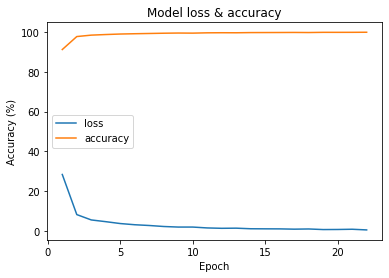

In [30]:
# Plot loass and accuracy
# Plot training & validation accuracy values
loss_list = [100 * i for i in hist.history['loss']]
acc_list = [100 * i for i in hist.history['accuracy']]

epochs = range(1, len(loss_list) + 1)

plt.plot(epochs,loss_list) 
plt.plot(epochs,acc_list) 
plt.title('Model loss & accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['loss', 'accuracy'], loc='center left')
plt.show()

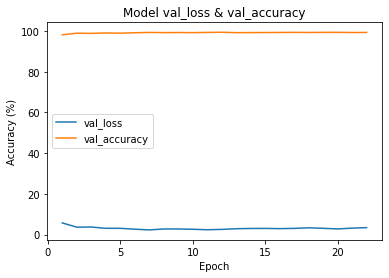

In [31]:
vloss_list = [100 * i for i in hist.history['val_loss']]
vacc_list = [100 * i for i in hist.history['val_accuracy']]
plt.plot(epochs,vloss_list)  
plt.plot(epochs,vacc_list)  
plt.title('Model val_loss & val_accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['val_loss', 'val_accuracy'], loc='center left')
plt.show()

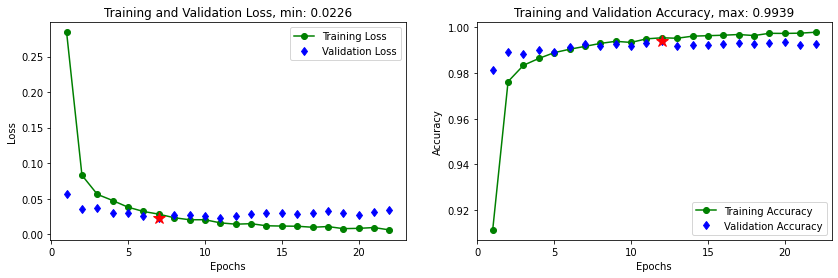

In [32]:
# More graphs of loss and accuracy
history_dict = hist.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'go-', label='Training Loss')
plt.plot(epochs, val_loss, 'bd', label='Validation Loss')
plt.plot(np.argmin(np.array(val_loss))+1,val_loss[np.argmin(np.array(val_loss))], 'r*', ms=12)
plt.title('Training and Validation Loss, min: ' + str(np.round(val_loss[np.argmin(np.array(val_loss))],4)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'go-', label='Training Accuracy') #, c='blue')
plt.plot(epochs, val_acc, 'bd', label='Validation Accuracy') #, c='red')
plt.plot(np.argmax(np.array(val_acc))+1,val_acc[np.argmax(np.array(val_acc))], 'r*', ms=12)
plt.title('Training and Validation Accuracy, max: ' + str(np.round(val_acc[np.argmax(np.array(val_acc))],4)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## [Next] fashion mnist model의 best model을 구하시오.

> fashion mnist 데이터 로딩
```
from keras.datasets import fashion_mnist
(X_train0, y_train0), (X_test0, y_test0) = fashion_mnist.load_data()
```

---

In [33]:
tf.random.set_seed(0)

print(tf.__version__)

2.7.0


In [37]:
# import TF2 submodules
from tensorflow.keras import layers, models, callbacks
from keras.datasets import fashion_mnist

(X_train0, y_train0), (X_test0, y_test0) = fashion_mnist.load_data()

# Reshape
X_train = X_train0.reshape(60000,28,28,1)
X_test = X_test0.reshape(10000,28,28,1)

# Normalization
X_train, X_test = X_train/255.0, X_test/255.0 # 정규화

print("X_train={0}".format(X_train.shape))
print("y_train={0}".format(y_train0.shape)) 
print("X_test={0}".format(X_test.shape))
print("y_test={0}".format(y_test0.shape))

4431872/4422102 [==============================] - 0s 0us/step
X_train=(60000, 28, 28, 1)
y_train=(60000,)
X_test=(10000, 28, 28, 1)
y_test=(10000,)


In [38]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)
y_train.shape,y_test.shape

((60000, 10), (10000, 10))

In [39]:
y_train0.shape, y_train.shape

((60000,), (60000, 10))

27439


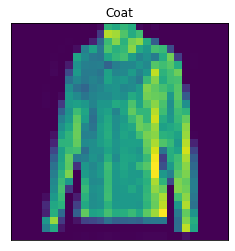

In [40]:
class_names =  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

idx = np.random.randint(0, X_train0.shape[0])
print(idx)
image = X_train0[idx]
plt.imshow(image) #, cmap=plt.get_cmap('gray'))
plt.title(class_names[y_train0[idx]])
plt.xticks([])
plt.yticks([])
plt.show()


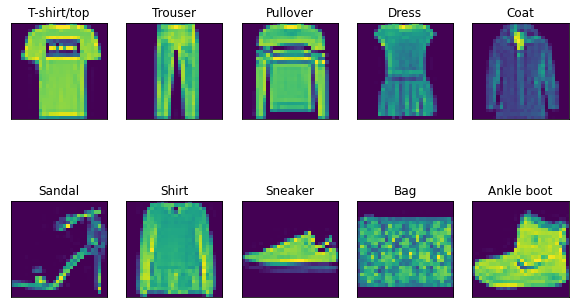

In [41]:
fig = plt.figure(figsize=(10,6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    num0_9 = X_train0[y_train0 == i]
    # print(num0_9.shape)
    plt.imshow(num0_9[0]) #, cmap='gray') #, interpolation='none')
    plt.title(class_names[i])
    plt.xticks([])
    plt.yticks([])
plt.show()